In [1]:
import collections
import concurrent.futures
import multiprocessing
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import median_abs_deviation
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.utils import shuffle
import tsfresh.feature_extraction.feature_calculators as calc

#### Сформуємо список файлів для подальшої обробки

In [2]:
BASE_FOLDER = Path(Path.cwd(), "data")
FOLDERS = ["idle", "running", "stairs", "walking"]

file_list = []

for folder in FOLDERS:
    folder_ = Path(BASE_FOLDER, folder)
    folder_file_list = [item for item in folder_.iterdir() if not item.is_dir()] 
    file_list += folder_file_list
print(len(file_list))

6462


#### Сформуємо список часових ознак та виберемо фунції для їх розрахунку

In [3]:
lock = multiprocessing.Manager().Lock()


def interquartile_range(column):
    quartiles = column.quantile([0.25, 0.75])
    return quartiles[0.75] - quartiles[0.25]


features = {"mean": np.mean, 
            "var": np.var, 
            "std": np.std, 
            "max": np.max, 
            "min": np.min, 
            "idxmax": np.argmax, 
            "idxmin": np.argmin,
            "median": np.median, 
            "mad": median_abs_deviation,
            "iqr": interquartile_range, 
#             "entropy": calc.sample_entropy,
            "kurtosis": calc.kurtosis,
            "rms": calc.root_mean_square,
            "skew": calc.skewness
           }

columns = ["acc_X", "acc_Y", "acc_Z"]

result_df_columns = [f"{col}_{feature}" for feature in features for col in columns] + ["cls_id"]
pd.array(result_df_columns)

<StringArray>
[    'acc_X_mean',     'acc_Y_mean',     'acc_Z_mean',      'acc_X_var',
      'acc_Y_var',      'acc_Z_var',      'acc_X_std',      'acc_Y_std',
      'acc_Z_std',      'acc_X_max',      'acc_Y_max',      'acc_Z_max',
      'acc_X_min',      'acc_Y_min',      'acc_Z_min',   'acc_X_idxmax',
   'acc_Y_idxmax',   'acc_Z_idxmax',   'acc_X_idxmin',   'acc_Y_idxmin',
   'acc_Z_idxmin',   'acc_X_median',   'acc_Y_median',   'acc_Z_median',
      'acc_X_mad',      'acc_Y_mad',      'acc_Z_mad',      'acc_X_iqr',
      'acc_Y_iqr',      'acc_Z_iqr', 'acc_X_kurtosis', 'acc_Y_kurtosis',
 'acc_Z_kurtosis',      'acc_X_rms',      'acc_Y_rms',      'acc_Z_rms',
     'acc_X_skew',     'acc_Y_skew',     'acc_Z_skew',         'cls_id']
Length: 40, dtype: string

In [4]:
def file_action(file: Path, lock=lock):
    global result_df
    
    df_tmp = pd.DataFrame() 
    df = pd.read_csv(file)
       
    for func in features.values():
        df_tmp = pd.concat([df_tmp, pd.DataFrame(df.apply(func, axis=0)).T], axis=1).reset_index(drop=True)
    df_tmp["cls_id"] = FOLDERS.index(file.parent.name) 
    
    with lock:
        result_df = pd.concat([result_df, df_tmp]).reset_index(drop=True)

#### Сформуємо наш загальний датасет з вибраними ознаками та збережемо його в файл

In [5]:
MAX_WORKERS = 8

result_df = pd.DataFrame()

with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    executor.map(file_action, file_list)
result_df.columns = result_df_columns
print(result_df.shape)
print(result_df.groupby("cls_id")["cls_id"].count())
result_df.to_csv(Path(BASE_FOLDER, "result_df.csv"), index=False)

(6462, 40)
cls_id
0    1039
1    3408
2     165
3    1850
Name: cls_id, dtype: int64


In [5]:
df = pd.read_csv(Path(BASE_FOLDER, "result_df.csv"))
display(df.head())

,acc_X_mean,acc_Y_mean,acc_Z_mean,acc_X_var,acc_Y_var,acc_Z_var,acc_X_std,acc_Y_std,acc_Z_std,acc_X_max,...,acc_X_kurtosis,acc_Y_kurtosis,acc_Z_kurtosis,acc_X_rms,acc_Y_rms,acc_Z_rms,acc_X_skew,acc_Y_skew,acc_Z_skew,cls_id
0,0.400949,-0.027134,9.753659,0.002735,0.002819,0.000345,0.052293,0.053096,0.018584,0.560243,...,2.553169,3.423107,-0.464052,0.404345,0.059628,9.753676,0.387552,-1.001079,0.453139,0
1,0.178448,0.167435,9.605697,1.038242,1.295378,0.160051,1.018942,1.138147,0.400064,5.099650,...,18.543171,12.224165,4.369874,1.034450,1.150396,9.614024,4.044308,3.647470,-2.365312,0
2,0.401109,-0.030007,9.755095,0.002824,0.002748,0.000461,0.053145,0.052424,0.021474,0.560243,...,2.273958,3.479078,-0.237219,0.404614,0.060405,9.755119,0.417794,-0.946561,0.503854,0
3,0.396799,-0.026975,9.757808,0.002769,0.002561,0.000580,0.052625,0.050607,0.024082,0.560243,...,2.671665,4.596610,0.356352,0.400273,0.057348,9.757838,0.639146,-1.123940,0.731909,0
4,0.400949,-0.029528,9.752541,0.002704,0.002874,0.000312,0.052000,0.053608,0.017665,0.560243,...,2.681374,3.002418,0.051784,0.404307,0.061203,9.752557,0.401492,-0.857829,0.565957,0


#### Перевіримо наявність пропусків та збалансованість нашого набору по категоріям

None values count: 0
Counting by category: {'idle': 1039, 'running': 3408, 'stairs': 165, 'walking': 1850}


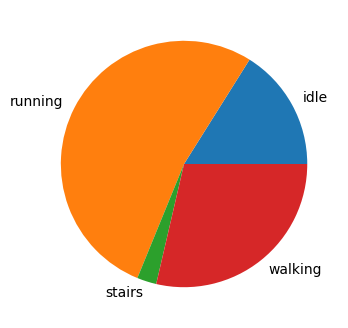

In [6]:
print(f"None values count: {df.isnull().sum().sum()}")
df_cat_count = df.groupby("cls_id")["cls_id"].count()
print(f"Counting by category: {dict(zip(FOLDERS, df_cat_count))}")

fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(df_cat_count, labels = FOLDERS)
ax.legend().set_visible(False);

Висновок: пропусків немає, але збалансованість під великим питанням.

#### Перевіримо масштаб ознак наприклад по X

In [7]:
columns_x = [col for col in result_df_columns if col.startswith("acc_X")]
df[columns_x].mean()

acc_X_mean         1.923550
acc_X_var         49.551305
acc_X_std          6.047206
acc_X_max         16.152018
acc_X_min         -8.995760
acc_X_idxmax      14.417673
acc_X_idxmin      14.244352
acc_X_median       1.336733
acc_X_mad          3.536796
acc_X_iqr          7.195191
acc_X_kurtosis     1.592901
acc_X_rms          7.434691
acc_X_skew         0.208089
dtype: float64

спробуємо обійтися без масштабування

#### Подивимось на їх попарні кореляції

In [8]:
df[columns_x].corr()

,acc_X_mean,acc_X_var,acc_X_std,acc_X_max,acc_X_min,acc_X_idxmax,acc_X_idxmin,acc_X_median,acc_X_mad,acc_X_iqr,acc_X_kurtosis,acc_X_rms,acc_X_skew
acc_X_mean,1.000000,0.732608,0.671501,0.881478,0.492392,-0.005457,-0.005635,0.972467,0.638291,0.651649,-0.156992,0.674118,0.598379
acc_X_var,0.732608,1.000000,0.954784,0.894330,-0.117104,-0.001126,0.009695,0.682876,0.873753,0.889626,-0.262176,0.940183,0.384913
acc_X_std,0.671501,0.954784,1.000000,0.896642,-0.244329,0.011326,0.001396,0.633196,0.924935,0.934302,-0.329877,0.985854,0.342640
acc_X_max,0.881478,0.894330,0.896642,1.000000,0.148171,0.007957,-0.001389,0.835869,0.812789,0.821209,-0.214201,0.882671,0.582630
acc_X_min,0.492392,-0.117104,-0.244329,0.148171,1.000000,-0.008988,-0.011419,0.463902,-0.206743,-0.192154,0.096698,-0.218755,0.486705
acc_X_idxmax,-0.005457,-0.001126,0.011326,0.007957,-0.008988,1.000000,-0.026568,0.000220,0.016256,0.016628,0.017817,0.011895,-0.009742
acc_X_idxmin,-0.005635,0.009695,0.001396,-0.001389,-0.011419,-0.026568,1.000000,-0.015669,-0.003174,-0.004280,0.012603,-0.000372,-0.003308
acc_X_median,0.972467,0.682876,0.633196,0.835869,0.463902,0.000220,-0.015669,1.000000,0.635312,0.626761,-0.152619,0.632793,0.544383
acc_X_mad,0.638291,0.873753,0.924935,0.812789,-0.206743,0.016256,-0.003174,0.635312,1.000000,0.969454,-0.401913,0.905603,0.298511
acc_X_iqr,0.651649,0.889626,0.934302,0.821209,-0.192154,0.016628,-0.004280,0.626761,0.969454,1.000000,-0.404828,0.922826,0.304791


#### Також за допомогою Random Forest подивимось на важливість ознак

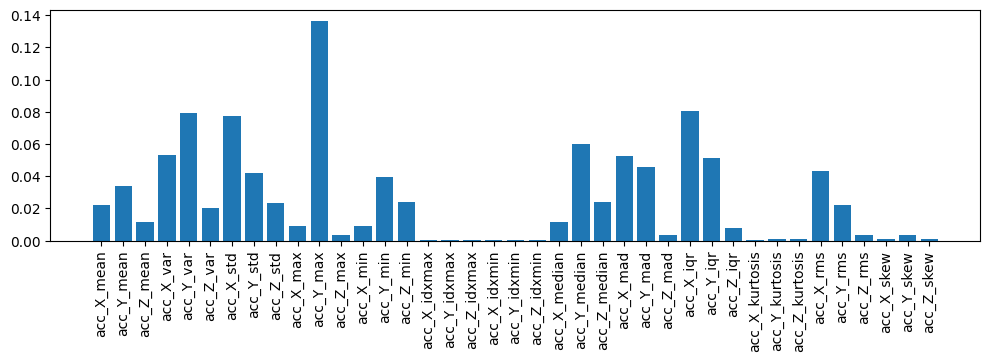

In [9]:
X = df[result_df_columns[:-1]]
y =  df["cls_id"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)

plt.figure(figsize=(12,3))
plt.bar(X.columns, rfc_model.feature_importances_)
plt.xticks(rotation=90);

#### A також такий прикол

In [10]:
cols = np.array(X_train.columns).reshape(-1, 3)
d = {}
for sub_cols in cols:
    svc_model = SVC()
    svc_model.fit(X_train[sub_cols], y_train)
    svc_prediction = svc_model.predict(X_test[sub_cols])
    d[", ".join(sub_cols)] = [f1_score(y_test, svc_prediction, average="macro")]
data = pd.DataFrame.from_dict(d, orient="index").reset_index()
data.columns = ["features", "f1_score"]
data.sort_values("f1_score", ascending=False)   

,features,f1_score
7,"acc_X_median, acc_Y_median, acc_Z_median",0.882725
3,"acc_X_max, acc_Y_max, acc_Z_max",0.741894
0,"acc_X_mean, acc_Y_mean, acc_Z_mean",0.738544
4,"acc_X_min, acc_Y_min, acc_Z_min",0.735466
1,"acc_X_var, acc_Y_var, acc_Z_var",0.735105
2,"acc_X_std, acc_Y_std, acc_Z_std",0.734616
9,"acc_X_iqr, acc_Y_iqr, acc_Z_iqr",0.732896
8,"acc_X_mad, acc_Y_mad, acc_Z_mad",0.730842
11,"acc_X_rms, acc_Y_rms, acc_Z_rms",0.730769
12,"acc_X_skew, acc_Y_skew, acc_Z_skew",0.601021


Із наведеного вище слідує, що можна спокійно? позбутися таких ознак, як idxmax та idxmin.

#### Підбір параметрів довіримо GridSearchCV

In [12]:
svc_model = SVC()
grid = {
    "C": [0.1, 1.0, 10.0, 100.0],
    "gamma": [0.01, 0.001, 0.0001],
    "kernel": ["rbf"]
} 

model = GridSearchCV(svc_model, grid, scoring="accuracy", cv=5,
                  n_jobs=-1, verbose=1, return_train_score=True).fit(X_train, y_train)

res_rbf = pd.DataFrame(model.cv_results_).filter(regex="^(?:mean|param)").sort_values("mean_test_score", ascending=False)
display(res_rbf.head(10))
print(f"Best params: {model.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,mean_fit_time,mean_score_time,param_C,param_gamma,param_kernel,params,mean_test_score,mean_train_score
7,0.523799,0.189599,10.0,0.001,rbf,"{'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}",0.998646,1.000000
10,0.541796,0.191201,100.0,0.001,rbf,"{'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}",0.998646,1.000000
11,0.076997,0.041601,100.0,0.0001,rbf,"{'C': 100.0, 'gamma': 0.0001, 'kernel': 'rbf'}",0.996711,0.999661
4,0.692601,0.170398,1.0,0.001,rbf,"{'C': 1.0, 'gamma': 0.001, 'kernel': 'rbf'}",0.994389,0.997001
8,0.074597,0.061600,10.0,0.0001,rbf,"{'C': 10.0, 'gamma': 0.0001, 'kernel': 'rbf'}",0.991100,0.993326
5,0.101996,0.060399,1.0,0.0001,rbf,"{'C': 1.0, 'gamma': 0.0001, 'kernel': 'rbf'}",0.976785,0.976833
1,0.723597,0.221802,0.1,0.001,rbf,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.973496,0.973834
2,0.224197,0.100399,0.1,0.0001,rbf,"{'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.972336,0.972287
6,2.748599,0.833199,10.0,0.01,rbf,"{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.871927,1.000000
9,2.505398,0.436599,100.0,0.01,rbf,"{'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.871927,1.000000


Best params: {'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}


In [13]:
svc_model = SVC()
grid = {
    "C": [0.1, 1.0, 10.0, 100.0],
    "gamma": [0.01, 0.001, 0.0001],
    "kernel": ["linear"]
} 

model = GridSearchCV(svc_model, grid, scoring="accuracy", cv=5,
                  n_jobs=-1, verbose=1, return_train_score=True).fit(X_train, y_train)

res_linear = pd.DataFrame(model.cv_results_).filter(regex="^(?:mean|param)").sort_values("mean_test_score", ascending=False)
display(res_linear.head(10))
print(f"Best params: {model.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,mean_fit_time,mean_score_time,param_C,param_gamma,param_kernel,params,mean_test_score,mean_train_score
6,0.787797,0.007201,10.0,0.01,linear,"{'C': 10.0, 'gamma': 0.01, 'kernel': 'linear'}",0.995164,0.999129
7,0.793597,0.009400,10.0,0.001,linear,"{'C': 10.0, 'gamma': 0.001, 'kernel': 'linear'}",0.995164,0.999129
8,0.788597,0.007599,10.0,0.0001,linear,"{'C': 10.0, 'gamma': 0.0001, 'kernel': 'linear'}",0.995164,0.999129
9,2.377400,0.006200,100.0,0.01,linear,"{'C': 100.0, 'gamma': 0.01, 'kernel': 'linear'}",0.994390,0.999710
10,2.305999,0.004200,100.0,0.001,linear,"{'C': 100.0, 'gamma': 0.001, 'kernel': 'linear'}",0.994390,0.999710
11,2.204400,0.004000,100.0,0.0001,linear,"{'C': 100.0, 'gamma': 0.0001, 'kernel': 'linear'}",0.994390,0.999710
3,0.220599,0.008800,1.0,0.01,linear,"{'C': 1.0, 'gamma': 0.01, 'kernel': 'linear'}",0.993229,0.997292
4,0.222600,0.009200,1.0,0.001,linear,"{'C': 1.0, 'gamma': 0.001, 'kernel': 'linear'}",0.993229,0.997292
5,0.223795,0.009200,1.0,0.0001,linear,"{'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}",0.993229,0.997292
0,0.090795,0.009400,0.1,0.01,linear,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}",0.992841,0.995115


Best params: {'C': 10.0, 'gamma': 0.01, 'kernel': 'linear'}


In [14]:
svc_model = SVC()
grid = {
    "C": [0.1, 1.0, 10.0, 100.0],
    "degree": [1, 2, 3, 4],
    "kernel": ["poly"]
} 
model = GridSearchCV(svc_model, grid, scoring="accuracy", cv=5,
                  n_jobs=-1, verbose=1, return_train_score=True).fit(X_train, y_train)

res_poly = pd.DataFrame(model.cv_results_).filter(regex="^(?:mean|param)").sort_values("mean_test_score", ascending=False)
display(res_poly.head(10))
print(f"Best params: {model.best_params_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,mean_fit_time,mean_score_time,param_C,param_degree,param_kernel,params,mean_test_score,mean_train_score
13,0.047798,0.014400,100.0,2,poly,"{'C': 100.0, 'degree': 2, 'kernel': 'poly'}",0.991681,0.993035
12,0.054599,0.012401,100.0,1,poly,"{'C': 100.0, 'degree': 1, 'kernel': 'poly'}",0.988392,0.989408
14,0.048399,0.015001,100.0,3,poly,"{'C': 100.0, 'degree': 3, 'kernel': 'poly'}",0.987811,0.989215
8,0.054600,0.016400,10.0,1,poly,"{'C': 10.0, 'degree': 1, 'kernel': 'poly'}",0.983942,0.984523
9,0.057197,0.017800,10.0,2,poly,"{'C': 10.0, 'degree': 2, 'kernel': 'poly'}",0.977559,0.977897
15,0.063002,0.014396,100.0,4,poly,"{'C': 100.0, 'degree': 4, 'kernel': 'poly'}",0.976398,0.976881
4,0.084199,0.021398,1.0,1,poly,"{'C': 1.0, 'degree': 1, 'kernel': 'poly'}",0.974463,0.974463
10,0.079202,0.023199,10.0,3,poly,"{'C': 10.0, 'degree': 3, 'kernel': 'poly'}",0.973883,0.974657
5,0.112598,0.028400,1.0,2,poly,"{'C': 1.0, 'degree': 2, 'kernel': 'poly'}",0.972336,0.972335
0,0.275407,0.046797,0.1,1,poly,"{'C': 0.1, 'degree': 1, 'kernel': 'poly'}",0.970981,0.970933


Best params: {'C': 100.0, 'degree': 2, 'kernel': 'poly'}


In [18]:
rfc_model = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=10, oob_score=True) 
grid = {
    "n_estimators": [50, 100, 200, 400],
    "max_features": ["sqrt", "log2"]
} 
model = GridSearchCV(rfc_model, grid, cv= 5).fit(X_train, y_train)
res_rfc = pd.DataFrame(model.cv_results_).sort_values("mean_test_score", ascending=False)
display(res_rfc.head(5))
print(f"Best params: {model.best_params_}")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,0.116800,0.002785,0.015599,0.000489,log2,50,"{'max_features': 'log2', 'n_estimators': 50}",0.997099,1.000000,0.999033,0.999033,0.999032,0.998839,0.000948,1
0,0.121600,0.003611,0.017400,0.000800,sqrt,50,"{'max_features': 'sqrt', 'n_estimators': 50}",0.997099,0.999033,0.999033,0.999033,0.998064,0.998452,0.000774,2
1,0.197252,0.002245,0.025000,0.000894,sqrt,100,"{'max_features': 'sqrt', 'n_estimators': 100}",0.995164,1.000000,0.999033,0.999033,0.997096,0.998065,0.001730,3
2,0.366206,0.004528,0.040994,0.000009,sqrt,200,"{'max_features': 'sqrt', 'n_estimators': 200}",0.995164,1.000000,0.999033,0.999033,0.997096,0.998065,0.001730,3
6,0.348201,0.002401,0.041398,0.000801,log2,200,"{'max_features': 'log2', 'n_estimators': 200}",0.995164,1.000000,0.999033,0.999033,0.997096,0.998065,0.001730,3


Best params: {'max_features': 'log2', 'n_estimators': 50}


#### Перевіряємо, чи не пожартував GridSearchCV

In [20]:
def print_f1_score(alg: str, scores_: list):
    print(f"{alg}, f1_score(macro)")
    print(f"test: {scores_[0]}, train: {scores_[1]}")    
    print("-"*60)

In [21]:
models = {"svc poly": SVC(C=100, degree=2, kernel="poly"), 
          "svc linear": SVC(C=10, gamma=0.01, kernel="linear"), 
          "svc rbf": SVC(C=10, gamma=0.001, kernel="rbf")}
for kernel, model in models.items():
    scores = []
    model.fit(X_train, y_train)
    
    scores.append(f1_score(y_test, model.predict(X_test), average='macro'))
    scores.append(f1_score(y_train, model.predict(X_train), average='macro'))
    
    print_f1_score(kernel, scores)

svc poly, f1_score(macro)
test: 0.9600946198701727, train: 0.95885235858689
------------------------------------------------------------
svc linear, f1_score(macro)
test: 0.970715249662618, train: 0.9906199448368964
------------------------------------------------------------
svc rbf, f1_score(macro)
test: 0.9874493927125507, train: 1.0
------------------------------------------------------------


In [23]:
model = RandomForestClassifier(max_features="log2", n_estimators=50).fit(X_train, y_train) 
scores = []
scores.append(f1_score(y_test, model.predict(X_test), average='macro'))
scores.append(f1_score(y_train, model.predict(X_train), average='macro'))
print_f1_score("rfc", scores)

rfc, f1_score(macro)
test: 0.9958164642375169, train: 1.0
------------------------------------------------------------


#### Варіант коли ми особливо не заморочуємося з ознаками

In [24]:
features = {"mean": np.mean, 
            "var": np.var, 
            "std": np.std, 
            "max": np.max, 
            "min": np.min 
           }

result_df_columns = [f"{col}_{feature}" for feature in features for col in columns] + ["cls_id"]

MAX_WORKERS = 8

result_df = pd.DataFrame()

with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    executor.map(file_action, file_list)
result_df.columns = result_df_columns
result_df.to_csv(Path(BASE_FOLDER, "result_df_min.csv"), index=False)

In [25]:
df = pd.read_csv(Path(BASE_FOLDER, "result_df_min.csv"))
X = df[result_df_columns[:-1]]
y =  df["cls_id"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [27]:
svc_model = SVC()
grid = {
    "C": [0.1, 1.0, 10.0, 100.0],
    "gamma": [0.01, 0.001, 0.0001],
    "kernel": ["rbf"]
} 

model = GridSearchCV(svc_model, grid, scoring="accuracy", cv=5,
                  n_jobs=-1, verbose=1, return_train_score=True).fit(X_train, y_train)

res = pd.DataFrame(model.cv_results_).filter(regex="^(?:mean|param)").sort_values("mean_test_score", ascending=False)
display(res.head(10))
print(f"Best params: {model.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,mean_fit_time,mean_score_time,param_C,param_gamma,param_kernel,params,mean_test_score,mean_train_score
10,0.178597,0.069600,100.0,0.001,rbf,"{'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}",0.998646,0.999758
7,0.174397,0.080000,10.0,0.001,rbf,"{'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}",0.995744,0.996905
6,1.605997,0.427600,10.0,0.01,rbf,"{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.994777,1.000000
9,1.330599,0.219000,100.0,0.01,rbf,"{'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.994777,1.000000
3,1.589198,0.415600,1.0,0.01,rbf,"{'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.993423,0.999323
4,0.180997,0.083201,1.0,0.001,rbf,"{'C': 1.0, 'gamma': 0.001, 'kernel': 'rbf'}",0.991100,0.992310
11,0.042798,0.030001,100.0,0.0001,rbf,"{'C': 100.0, 'gamma': 0.0001, 'kernel': 'rbf'}",0.990326,0.991875
8,0.041598,0.043401,10.0,0.0001,rbf,"{'C': 10.0, 'gamma': 0.0001, 'kernel': 'rbf'}",0.989552,0.989166
1,0.220597,0.120800,0.1,0.001,rbf,"{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",0.974463,0.974463
5,0.057198,0.052599,1.0,0.0001,rbf,"{'C': 1.0, 'gamma': 0.0001, 'kernel': 'rbf'}",0.974463,0.974463


Best params: {'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}


In [28]:
model = SVC(C=100, gamma=0.001, kernel="rbf").fit(X_train, y_train)
scores = []
scores.append(f1_score(y_test, model.predict(X_test), average='macro'))
scores.append(f1_score(y_train, model.predict(X_train), average='macro'))
print_f1_score("rbf", scores)

rbf, f1_score(macro)
test: 0.9830272911051213, train: 0.9989649987222998
------------------------------------------------------------


In [29]:
rfc_model = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=10, oob_score=True) 
grid = {
    "n_estimators": [50, 100, 200, 400],
    "max_features": ["sqrt", "log2"]
} 
model = GridSearchCV(rfc_model, grid, cv=5).fit(X_train, y_train)
res_rfc = pd.DataFrame(model.cv_results_).sort_values("mean_test_score", ascending=False)
display(res_rfc.head(5))
print(f"Best params: {model.best_params_}")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.096401,0.002059,0.016429,0.000570,sqrt,50,"{'max_features': 'sqrt', 'n_estimators': 50}",0.998066,1.0,0.999033,1.0,0.998064,0.999033,0.000865,1
6,0.307203,0.002040,0.039398,0.000490,log2,200,"{'max_features': 'log2', 'n_estimators': 200}",0.998066,1.0,0.999033,1.0,0.998064,0.999033,0.000865,1
2,0.319803,0.024202,0.039197,0.000748,sqrt,200,"{'max_features': 'sqrt', 'n_estimators': 200}",0.997099,1.0,0.999033,1.0,0.998064,0.998839,0.001128,3
1,0.163201,0.002787,0.024199,0.000399,sqrt,100,"{'max_features': 'sqrt', 'n_estimators': 100}",0.998066,1.0,0.999033,1.0,0.997096,0.998839,0.001129,4
3,0.529202,0.000748,0.070295,0.001469,sqrt,400,"{'max_features': 'sqrt', 'n_estimators': 400}",0.998066,1.0,0.999033,1.0,0.997096,0.998839,0.001129,4


Best params: {'max_features': 'sqrt', 'n_estimators': 50}


In [30]:
model = RandomForestClassifier(max_features="sqrt", n_estimators=50).fit(X_train, y_train) 
scores = []
scores.append(f1_score(y_test, model.predict(X_test), average='macro'))
scores.append(f1_score(y_train, model.predict(X_train), average='macro'))
print_f1_score("rfc", scores)

rfc, f1_score(macro)
test: 0.9958164642375169, train: 1.0
------------------------------------------------------------


#### Варіант з сирими данними

In [31]:
lock = multiprocessing.Manager().Lock()
columns_raw = ["acc_X", "acc_Y", "acc_Z", "cls_id"]

def file_action_1(file: Path, lock=lock):
    global df_raw
    
    df = pd.read_csv(file)
    df["cls_id"] = FOLDERS.index(file.parent.name) 
    
    with lock:
        df_raw = pd.concat([df_raw, df]).reset_index(drop=True)

In [32]:
MAX_WORKERS = 8

df_raw = pd.DataFrame()

with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    executor.map(file_action_1, file_list)
df_raw.columns = columns_raw
print(df_raw.shape)
df_raw.to_csv(Path(BASE_FOLDER, "result_df_raw.csv"), index=False)

(193860, 4)


In [33]:
df = pd.read_csv(Path(BASE_FOLDER, "result_df_raw.csv"))
X = df[columns_raw[:-1]]
y =  df["cls_id"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [34]:
rfc_model = RandomForestClassifier(n_jobs=-1, max_features="sqrt", n_estimators=10, oob_score=True) 
grid = {
    "n_estimators": [50, 100],
    "max_features": ["sqrt", "log2"]
} 
model = GridSearchCV(rfc_model, grid, cv=5).fit(X_train, y_train)
res_rfc = pd.DataFrame(model.cv_results_).sort_values("mean_test_score", ascending=False)
display(res_rfc.head(5))
print(f"Best params: {model.best_params_}")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,2.288440,0.018244,0.061199,0.000400,log2,100,"{'max_features': 'log2', 'n_estimators': 100}",0.999549,0.999549,0.999516,0.999613,0.999936,0.999632,0.000155,1
1,2.277167,0.050762,0.061399,0.001497,sqrt,100,"{'max_features': 'sqrt', 'n_estimators': 100}",0.999549,0.999484,0.999516,0.999613,0.999936,0.999620,0.000164,2
0,1.260651,0.015074,0.038600,0.001356,sqrt,50,"{'max_features': 'sqrt', 'n_estimators': 50}",0.999516,0.999549,0.999549,0.999549,0.999936,0.999620,0.000158,3
2,1.299631,0.018474,0.041405,0.001354,log2,50,"{'max_features': 'log2', 'n_estimators': 50}",0.999420,0.999516,0.999549,0.999581,0.999903,0.999594,0.000164,4


Best params: {'max_features': 'log2', 'n_estimators': 100}


In [35]:
model = RandomForestClassifier(max_features="log2", n_estimators=100).fit(X_train, y_train) 
scores = []
scores.append(f1_score(y_test, model.predict(X_test), average='macro'))
scores.append(f1_score(y_train, model.predict(X_train), average='macro'))
print_f1_score("rfc", scores)

rfc, f1_score(macro)
test: 0.9993551113734707, train: 1.0
------------------------------------------------------------


### Висновки

#### I. Результати по F-мірі.
(F-міра розраховувалась з параметром average = "macro" так як у нас на вході незбалансований набір данних.)
1. Найкращий f1_score: test: 0.9993551113734707, train: 1.0 - __RFC scikit-learn на сирих данних__.
2. __RFC__ scikit-learn показав найкращі результати по всім 3 наборам.
    * датасет з 13 ознаками: test: 0.9958164642375169, train: 1.0
    * датасет з 5 ознаками: test: 0.9958164642375169, train: 1.0
    * сирий датасет: 0.9993551113734707, train: 1.0
3. __SVM__ також непогано справився з роботою (найкраще з ядром __rbf__):   
    * датасет з 13 ознаками: test: 0.9874493927125507, train: 1.0
    * датасет з 5 ознаками: test: 0.9830272911051213, train: 0.9989649987222998
    * сирий датасет: не досліджувалось із-за різкого зростання часу виконання.
#### II. Кількість ознак.
1. Кількість ознак особливо не вплинула на результати що може свідчити про те що тут головне їх якість.
#### III. Сирі данні.
1. Алгоритм __RFC scikit-learn__ на сирих данних продемонстрував найкращий результат, але зі зростанням об'єму вхідних данних помітно зростає час виконання. Робота __SVM__ на сирих данних була примусово перервана, щоб не перетворювати ноут на обігрівач. Тому введення статистичних ознак є гарним методом зменшити час виконання без значного погіршення якості.